# PyTorch Geometric concetti di base
PyTorch Geometric (PyG) è una libreria, estensione per PyTorch. Fornisce utili primitive per lo sviluppo di modelli di Graph Deep Learning, tra cui vari graph neural network layers e un gran numero di set di dati di benchmark.

## Introduzione

Recentemente, il deep learning sui grafi è emerso come uno dei campi di ricerca più caldi nella comunità del deep learning.
Le **Reti Neurali Grafiche (GNN)** mirano a generalizzare i concetti classici di deep learning a dati strutturati in modo irregolare (a differenza di immagini o testi) e a consentire alle reti neurali di ragionare sugli oggetti e sulle loro relazioni.

Questo tutorial vi introdurrà ad alcuni concetti fondamentali riguardanti il deep learning sui grafi tramite le Graph Neural Networks basate sulla **[libreria PyTorch Geometric (PyG)](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric è una libreria di estensione del popolare framework di deep learning [PyTorch](https://pytorch.org/) e consiste in vari metodi e  per semplificare l'implementazione di reti neurali grafiche.


Vediamo come creare i dati per la GNN  e costruire un layer di *MessagePassing* (core delle GNN).

# Come vengono rappresentati i grafi in PyG
Il modulo *torch_geometric.data* contiene una classe *Data* che consente di creare grafi in modo molto semplice. È sufficiente specificare gli attributi/caratteristiche associati a ciascun nodo la connettività di ciascun nodo.
Utilizziamo il seguente grafo per dimostrare come creare un oggetto Data
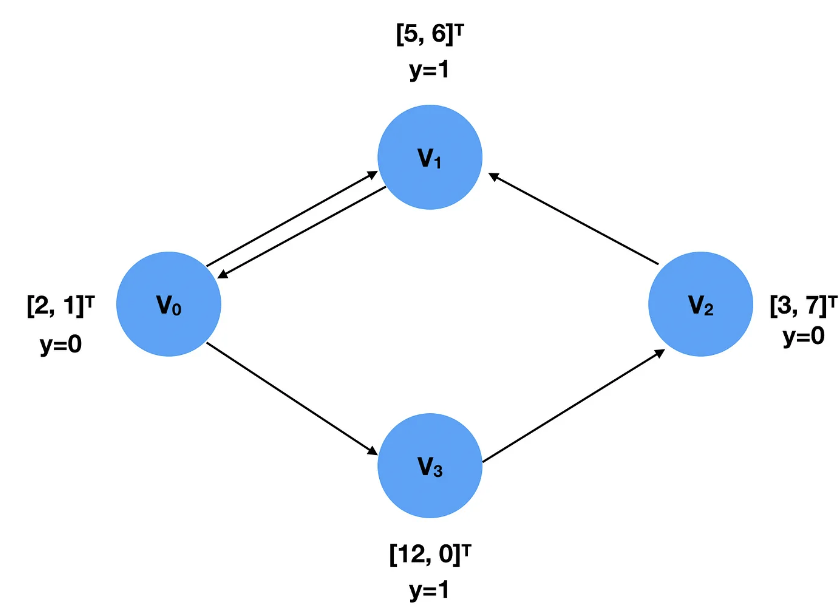

Ci sono 4 nodi nel grafo, V1 ... V4, ognuno dei quali è associato a un vettore di caratteristiche bidimensionale e a un'etichetta y che indica la sua classe. Questi due elementi possono essere rappresentati come *FloatTensors*: 

In [3]:
import torch
from torch_geometric.data import Data

x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

Stampando `edge_index`, possiamo capire meglio come PyG rappresenta internamente la connettività del grafo.
Possiamo vedere che per ogni bordo, `edge_index` contiene una tupla di due indici di nodo, dove il primo valore descrive l'indice del nodo sorgente e il secondo l'indice del nodo di destinazione di un bordo.

Questa rappresentazione è nota come **formato COO (formato di coordinate)** comunemente usato per rappresentare matrici rade.
Invece di contenere le informazioni di adiacenza in una rappresentazione densa $\mathbf{A} \in \{ 0, 1 \}^{|\mathbb{V}| \times |\mathbb{V}|}$, PyG rappresenta i grafi in modo rado, ossia mantenendo solo le coordinate/valori per i quali le voci in $\mathbf{A}$ sono non nulle.

Possiamo visualizzare ulteriormente il grafo convertendolo nel formato della libreria `networkx`, che implementa, oltre alle funzionalità di manipolazione del grafo, potenti strumenti di visualizzazione:

In [2]:
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

Mettiamo tutto assieme



Ogni grafo in PyTorch Geometric è rappresentato da un singolo oggetto [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data), che contiene tutte le informazioni per descrivere la sua rappresentazione grafica.
Possiamo stampare l'oggetto dati in qualsiasi momento tramite `print(data)` per ricevere un breve riassunto dei suoi attributi e delle loro forme:
```
Data(x=[4, 2], edge_index=[2, 5], y=[4])
```
Possiamo vedere che questo oggetto `data` contiene 3 attributi:
(1) La proprietà `edge_index` contiene le informazioni sulla **connettività del grafo**, *cioè una tupla di indici dei nodi di origine e di destinazione per ogni bordo.
PyG si riferisce inoltre a (2) **caratteristiche dei nodi** come `x` (a ciascuno dei 4 nodi è assegnato un vettore di caratteristiche di 2 dimensioni) e a (3) **etichette dei nodi** come `y` (a ciascun nodo è assegnata esattamente una classe).
(4) Esiste anche un attributo aggiuntivo chiamato `train_mask`, che descrive per quali nodi conosciamo già le loro assegnazioni alla comunità.
In totale, siamo a conoscenza delle etichette di verità di 4 nodi (uno per ogni comunità) e il compito è quello di dedurre l'assegnazione della comunità per i nodi rimanenti.

L'oggetto `data' fornisce anche alcune **funzioni di utilità** per dedurre alcune proprietà di base del grafo sottostante.
Ad esempio, si può facilmente dedurre se nel grafo esistono nodi isolati (*cioè non esiste alcun bordo verso alcun nodo), se il grafo contiene autocicli (*cioè, $(v, v) \ in \mathbb{E}$) o se il grafo è indiretto (*cioè, per ogni bordo $(v, w) \ in \mathbb{E}$ esiste anche il bordo $(w, v) \ in \mathbb{E}$).

In [2]:
import torch
from torch_geometric.data import Data


x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

edge_index = torch.tensor([[0, 2, 1, 0, 3],
                           [3, 1, 0, 1, 2]], dtype=torch.long)


data = Data(x=x, y=y, edge_index=edge_index)
data

Data(x=[4, 2], edge_index=[2, 5], y=[4])

# Data Loader

La classe *DataLoader* consente di immettere nel modello i dati per batch. Per creare un oggetto DataLoader, è sufficiente specificare il dataset e la dimensione del batch desiderata.

```
loader = DataLoader(dataset, batch_size=512, shuffle=True)
```

Ogni iterazione di un oggetto DataLoader produce un oggetto Batch, che è molto simile a un oggetto Data, ma con un attributo, "batch". Indica a quale grafo è associato ogni nodo. Poiché un DataLoader aggrega x, y e edge_index da diversi campioni/grafi in Batch, il modello GNN ha bisogno di questa informazione "batch" per sapere quali nodi appartengono allo stesso grafo all'interno di un batch per eseguire i calcoli.

```
per batch in loader:
    batch
    >>> Batch(x=[1024, 21], edge_index=[2, 1568], y=[512], batch=[1024])
```


# Un problema di classificazione

Seguendo [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), ci immergiamo nel mondo delle GNN esaminando un semplice esempio strutturato a grafo, la nota [**rete del club di karate di Zachary**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). Questo grafo descrive una rete sociale di 34 membri di un club di karate e documenta i collegamenti tra i membri che hanno interagito al di fuori del club. In questo caso, siamo interessati a individuare le comunità che nascono dall'interazione tra i membri.

# Formuliamo il problema 

-Abbiamo bisogno:
-del grafo e delle etichette per ogni nodo
-degli archi in Coordinate Format (COO)
-Embeddings o rappresentazione numerica dei nodi

*Nota: per la rappresentazione numerica dei nodi possiamo usare proprietà del grafo come il degree o usare diversi metodi di embedding es node2vec, DeepWalk*

In [6]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Numero di nodi del grafo: {len(dataset)}')
print(f'Numero di feature: {dataset.num_features}')
print(f'Numero di classi: {dataset.num_classes}')

Dataset: KarateClub():
Numero di nodi del grafo: 1
Numero di feature: 34
Numero di classi: 4


In [9]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Numero di nodi: {data.num_nodes}')
print(f'Numero di archi: {data.num_edges//2}')
print(f'Degree medio: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Numerdo di nodi di training: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contiene nodi isolati: {data.has_isolated_nodes()}')
print(f'Contiene self-loop: {data.has_self_loops()}')
print(f'Non direzionato: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Numero di nodi: 34
Numero di archi: 78
Degree medio: 4.59
Numerdo di nodi di training: 4
Training node label rate: 0.12
Contiene nodi isolati: False
Contiene self-loop: False
Non direzionato: True


In [12]:
# Funzione per la visualizzazione
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Funzione per visualizzare grafi NX o tensori PyTorch
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

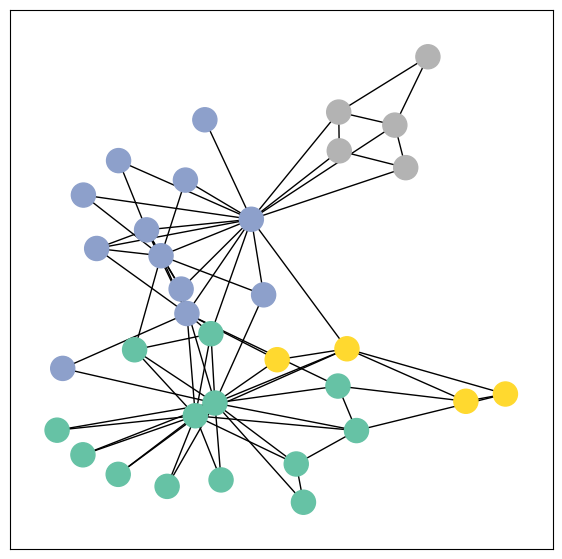

In [13]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

## Implementare le reti neurali grafiche (GNN)

Dopo aver appreso la gestione dei dati di PyG, è il momento di implementare la nostra prima Rete Neurale Grafica!

A tal fine, utilizzeremo uno degli operatori GNN più semplici, il livello **GCN** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)).

PyG implementa questo strato tramite [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), che può essere eseguito passando la rappresentazione della caratteristica del nodo `x` e la rappresentazione della connettività del grafo COO `edge_index`.

### Qual è l'output di un GNN?

L'obiettivo di un GNN è prendere in input un grafo $G = (\mathbb{V}, \mathbb{E})$ dove ogni nodo $v_i \ in \mathbb{V}$ ha un vettore di caratteristiche in input $X_i^{(0)}$. Quello che vogliamo imparare è una funzione $f_G : \mathbb{V} \mathbb{R}^{d_1} \mathbb{R}^{d_2} $, una funzione che riceve un nodo e il suo vettore di caratteristiche, così come la struttura del grafo, e produce un _embedding_, un vettore che rappresenta quel nodo in un modo utile per il nostro compito a valle. Una volta mappati i nodi e le loro caratteristiche iniziali sul loro embedding appreso, possiamo usare tali embedding per eseguire una serie di compiti diversi, tra cui la regressione/classificazione a livello di nodo, di arco o di grafo.

In questo laboratorio, vogliamo imparare gli embeddings che saranno utili per classificare ogni nodo nella sua comunità, quindi stiamo lavorando con un problema di classificazione a livello di nodo.

A questo punto siamo pronti a creare la nostra prima rete neurale a grafo, definendo l'architettura della rete in una classe torch.nn.Module:

In [14]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Spazio finale dell'embedding GNN.

        # Applichiamo uno step finale per la classificazione (modello lineare)
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Qui, per prima cosa inizializziamo tutti i nostri blocchi costruttivi in `__init__` e definiamo il flusso di calcolo della nostra rete in `forward`.
Per prima cosa definiamo e impiliamo **tre layer di convoluzione del grafo**. Ogni layer corrisponde all'aggregazione di informazioni provenienti dal vicinato a 1 hop di ogni nodo (i suoi vicini diretti), ma quando componiamo i layer insieme, siamo in grado di aggregare informazioni dal vicinato a 3 hop di ogni nodo (tutti i nodi fino a 3 “hop” di distanza).

Inoltre, i livelli `GCNConv` riducono la dimensionalità delle caratteristiche dei nodi a $2$, *cioè*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Ciascun livello `GCNConv` è potenziato da una non-linearità [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh).

Dopodiché, applichiamo una singola trasformazione lineare ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) che funge da classificatore per mappare i nostri nodi in una delle 4 classi/comunità.

Restituiamo sia l'output del classificatore finale sia l'embedding finale dei nodi prodotto dal nostro GNN.
Procediamo a inizializzare il nostro modello finale tramite `GCN()`, e stampando il nostro modello produciamo un riepilogo di tutti i suoi sottomoduli utilizzati.

Embedding shape: [34, 2]


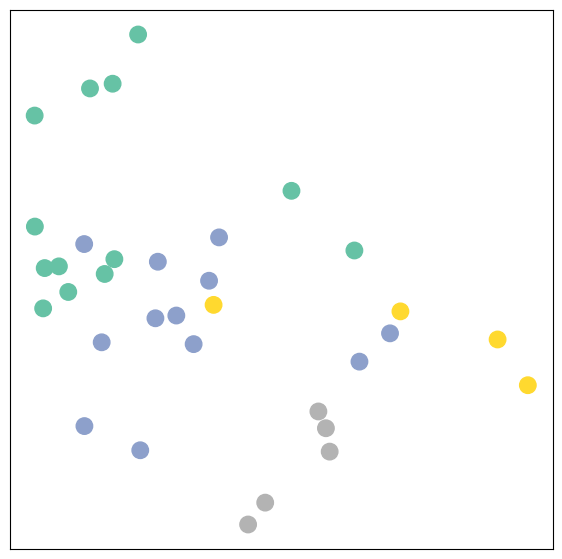

In [15]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'spazio di embedding: {list(h.shape)}')

visualize(h, color=data.y)

È notevole che, anche prima di addestrare i pesi del nostro modello, quest'ultimo produca un embedding di nodi che assomiglia molto alla struttura comunitaria del grafo.
I nodi dello stesso colore (comunità) sono già strettamente raggruppati nello spazio di embedding, anche se i pesi del nostro modello sono inizializzati **completamente a caso** e non abbiamo ancora eseguito alcun addestramento!
Questo porta alla conclusione che i GNN introducono un forte bias induttivo, portando a embedding simili per i nodi che sono vicini tra loro nel grafo di input.

### Addestramento sulla rete del Karate Club

Ma possiamo fare di meglio? Vediamo un esempio di come addestrare i parametri della nostra rete sulla base della conoscenza delle assegnazioni di comunità di 4 nodi del grafo (uno per ogni comunità):

Poiché tutto nel nostro modello è differenziabile e parametrizzato, possiamo aggiungere alcune etichette, allenare il modello e osservare come risultano gli embedding.
In questo caso, utilizziamo una procedura di apprendimento semi-supervisionato o trasduttivo: Ci alleniamo semplicemente rispetto a un nodo per classe, ma possiamo utilizzare tutti i dati del grafo di input.


L'addestramento del nostro modello è molto simile a quello di qualsiasi altro modello PyTorch.
Oltre a definire l'architettura della nostra rete, definiamo un criterio di loss (qui, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) e inizializziamo un ottimizzatore di gradienti stocastico (qui, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
Successivamente, si eseguono più cicli di ottimizzazione, dove ogni ciclo consiste in un passaggio in avanti e uno indietro per calcolare i gradienti dei parametri del modello rispetto alla perdita derivata dal passaggio in avanti.
Se non siete nuovi a PyTorch, questo schema dovrebbe sembrarvi familiare.
Altrimenti, la documentazione di PyTorch fornisce [una buona introduzione su come addestrare una rete neurale in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

Si noti che il nostro scenario di apprendimento semi-supervisionato si ottiene con la seguente riga:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
Mentre calcoliamo gli embeddings dei nodi per tutti i nostri nodi, **utilizziamo solo i nodi di addestramento per calcolare la perdita**.
In questo caso, ciò viene implementato filtrando l'output del classificatore `out` e le etichette di verità a terra `data.y` in modo che contengano solo i nodi della `train_mask`.

Ora iniziamo l'addestramento e vediamo come si evolvono le incorporazioni dei nodi nel tempo (meglio se eseguite esplicitamente il codice):

<IPython.core.display.Javascript object>

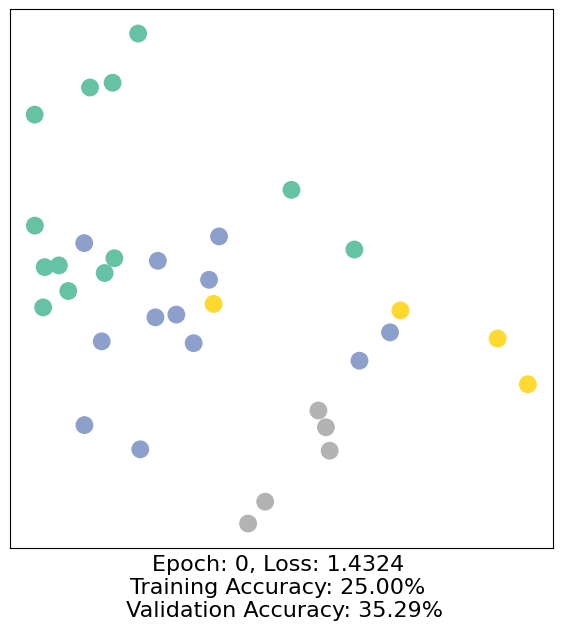

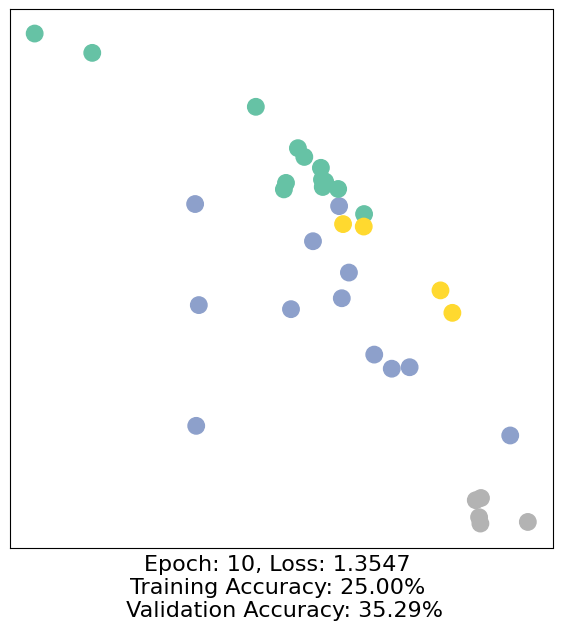

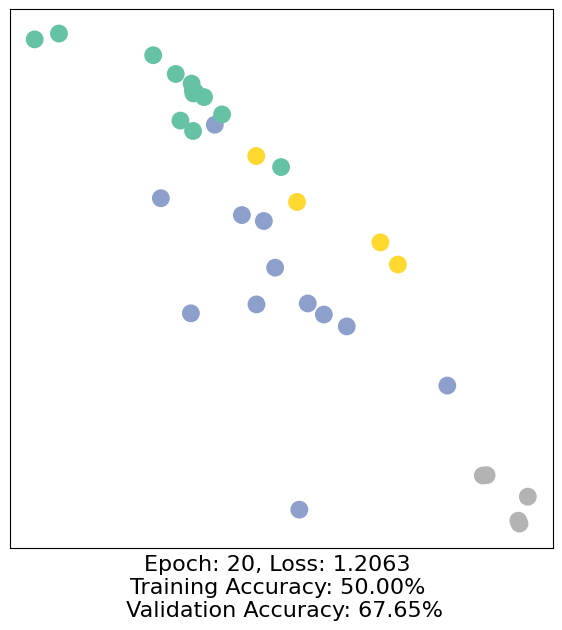

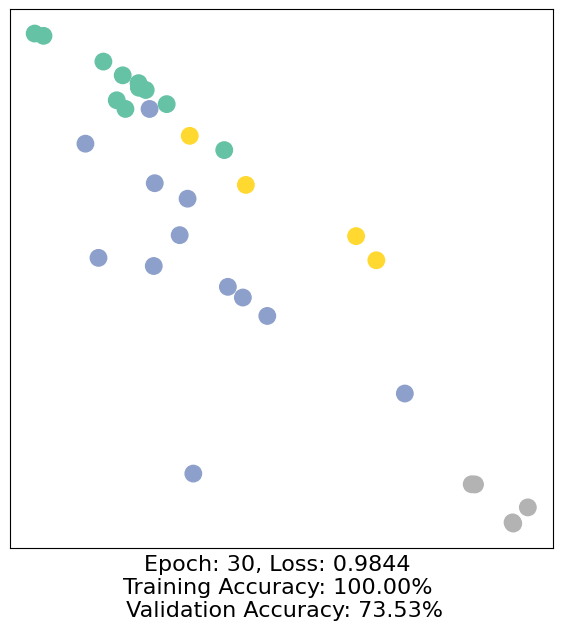

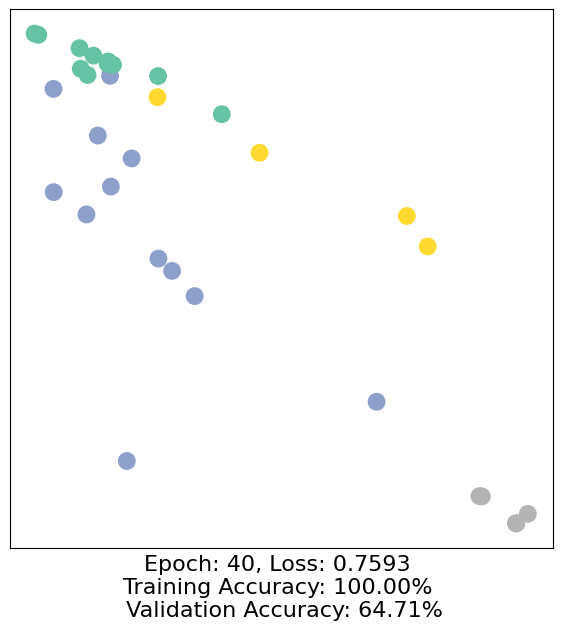

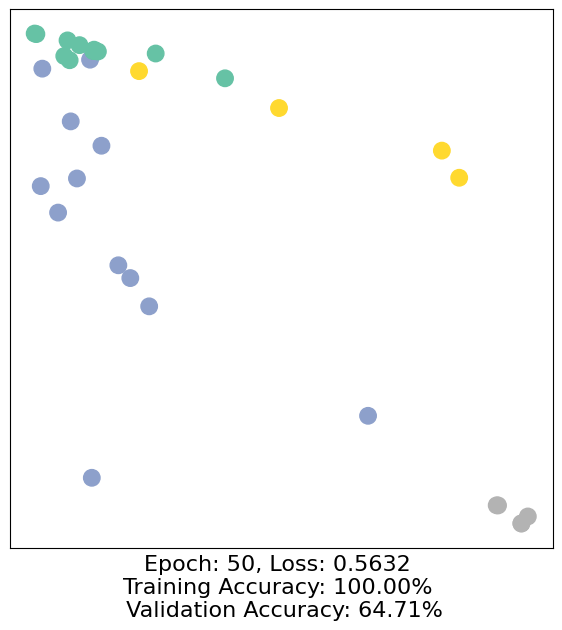

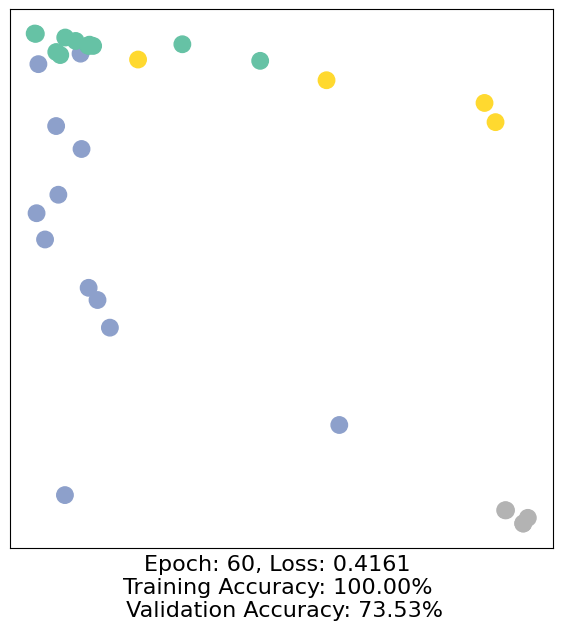

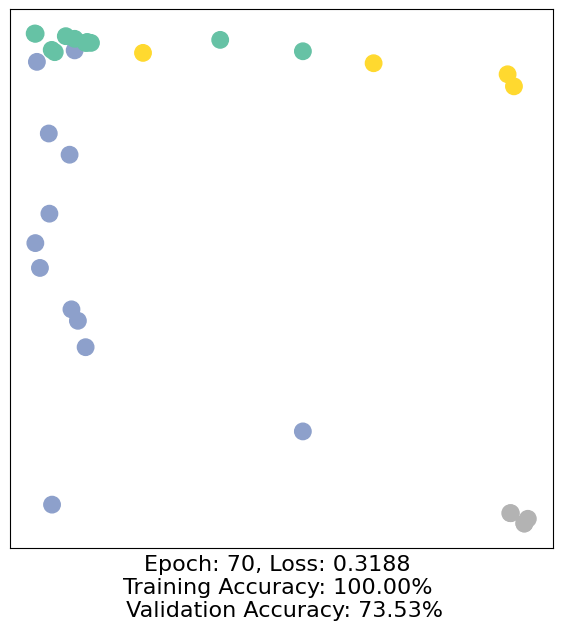

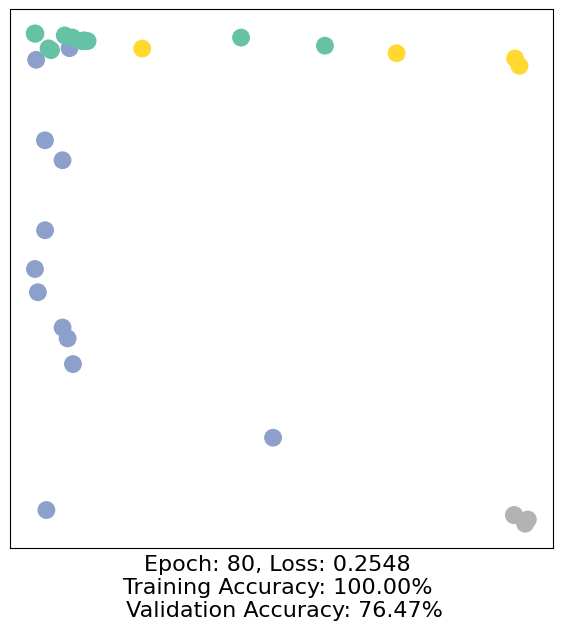

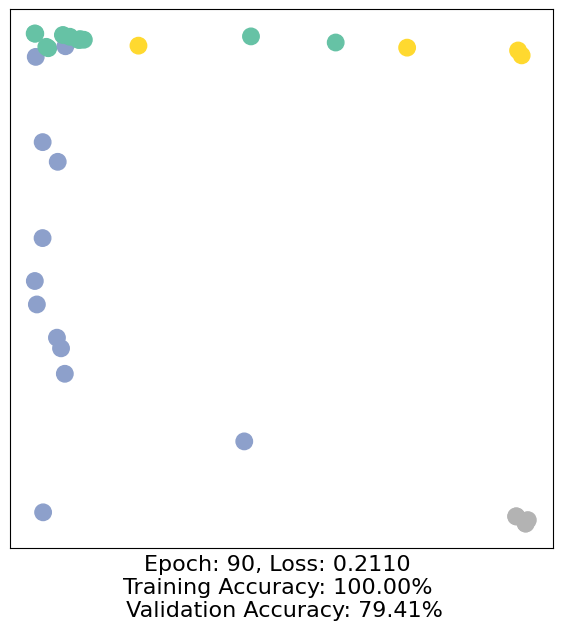

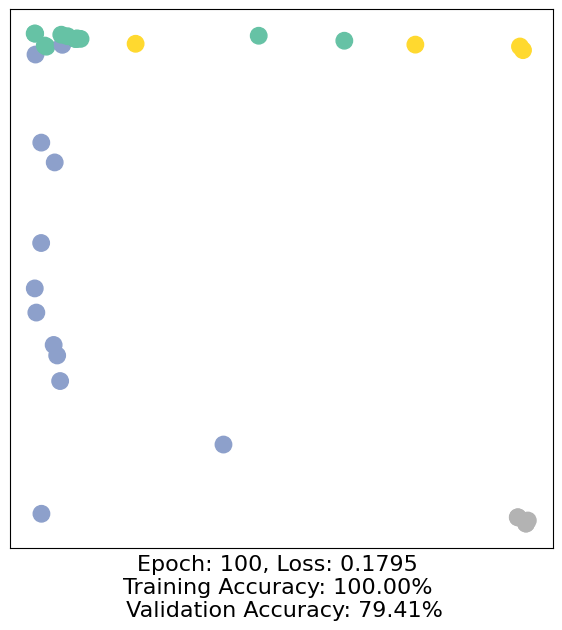

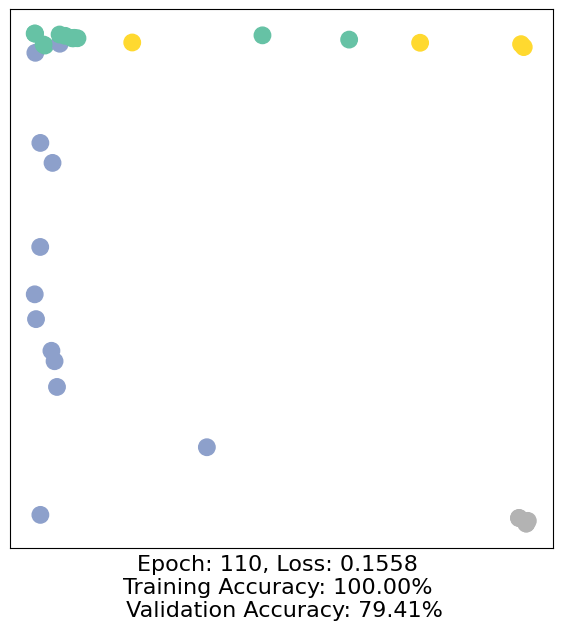

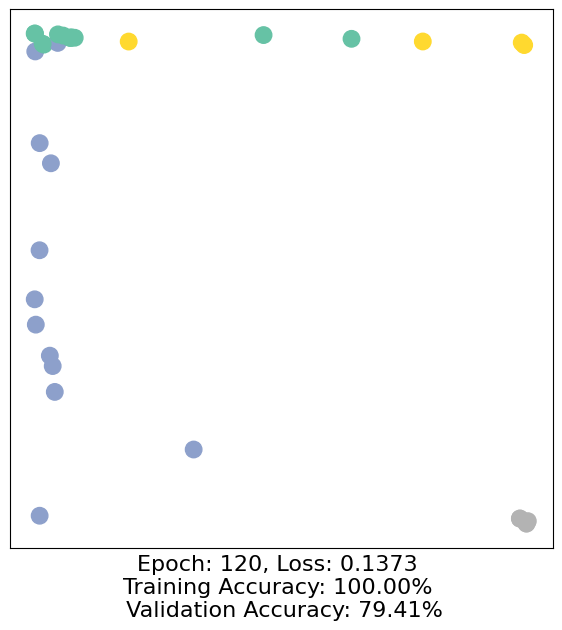

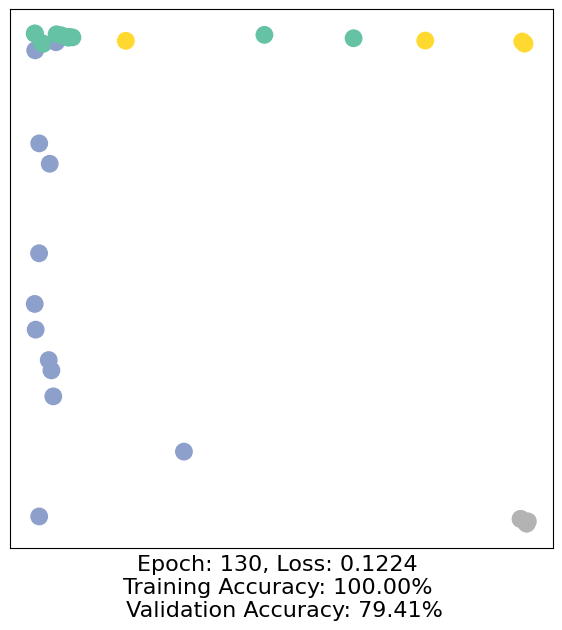

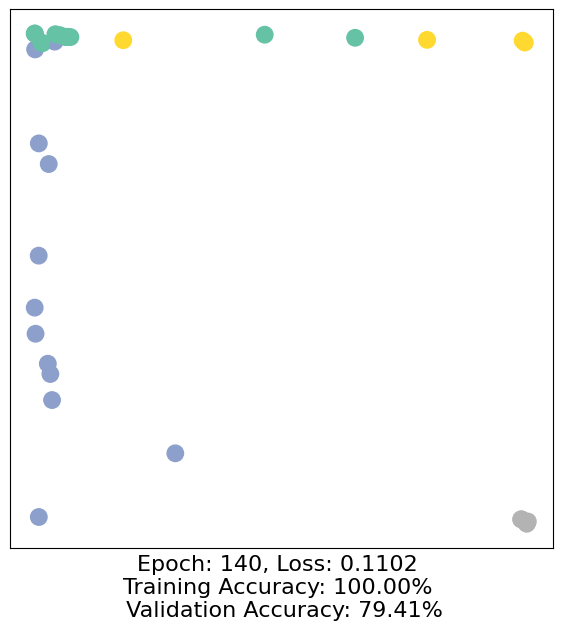

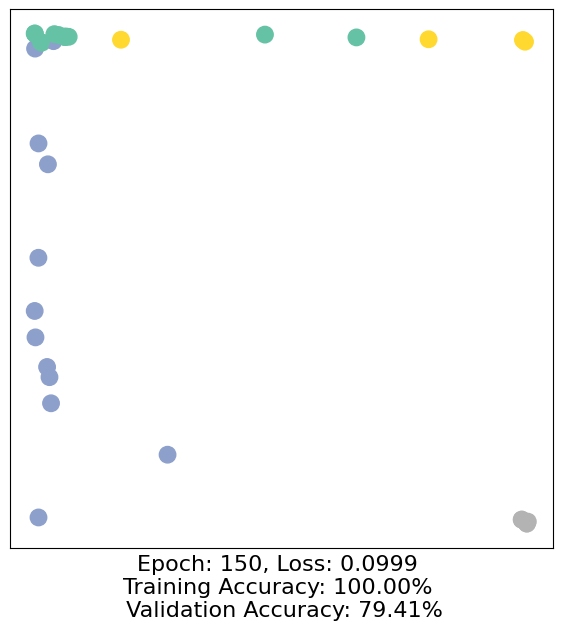

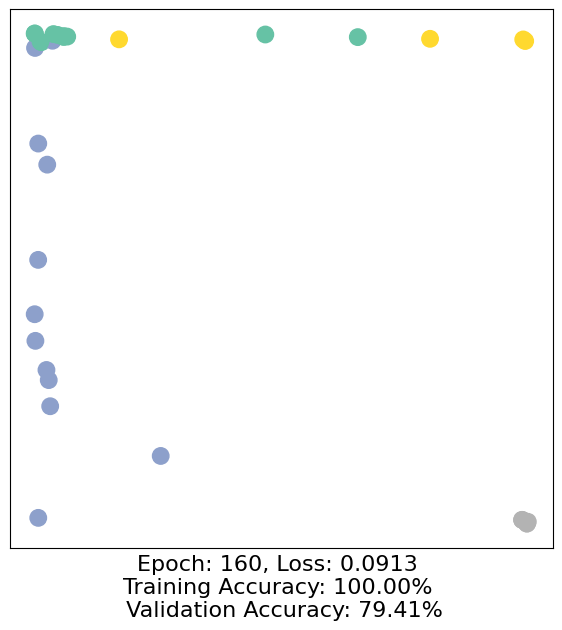

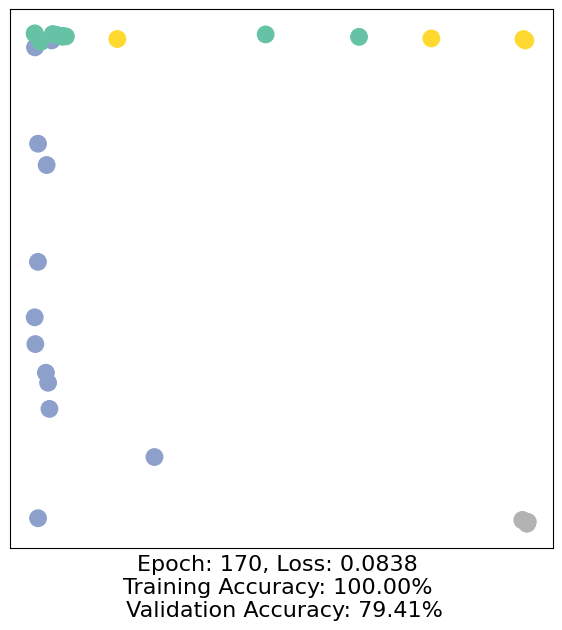

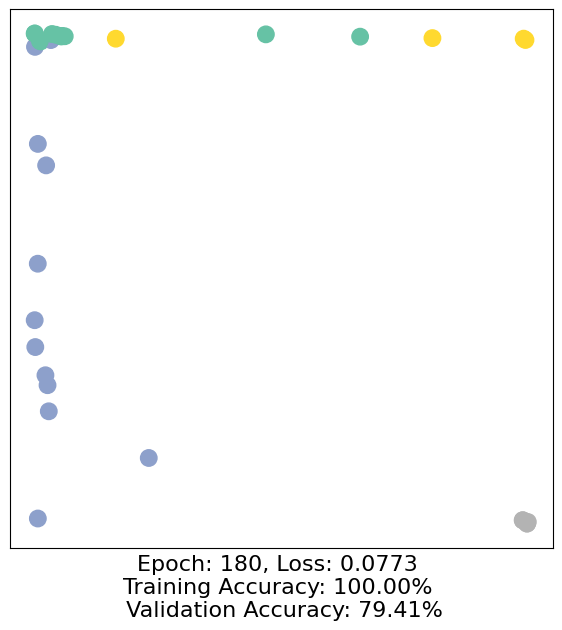

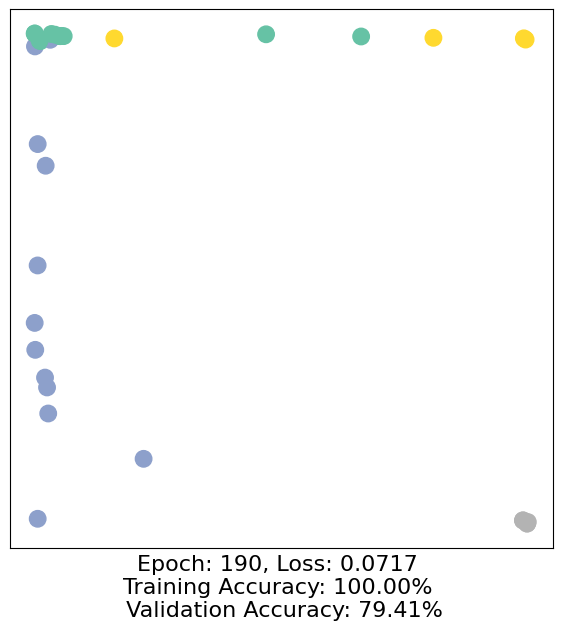

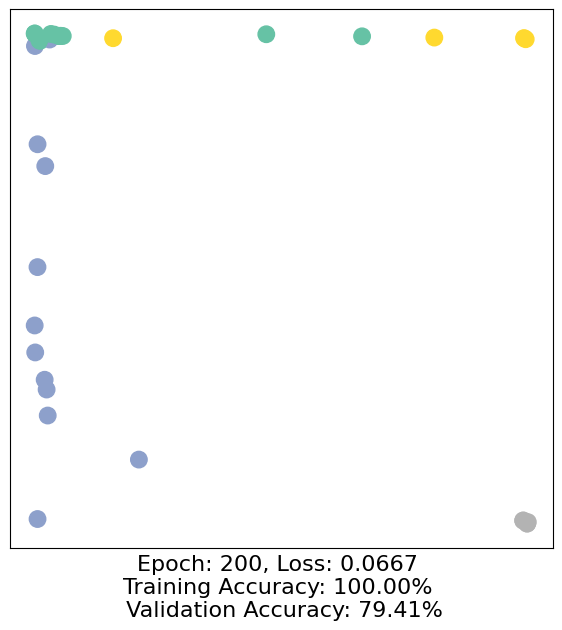

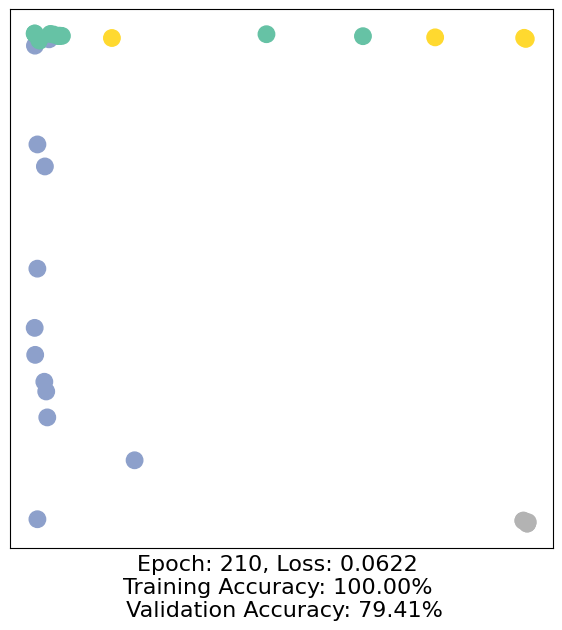

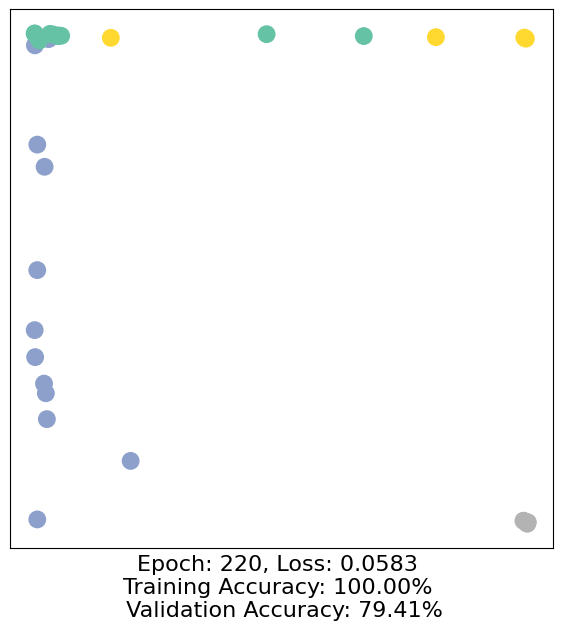

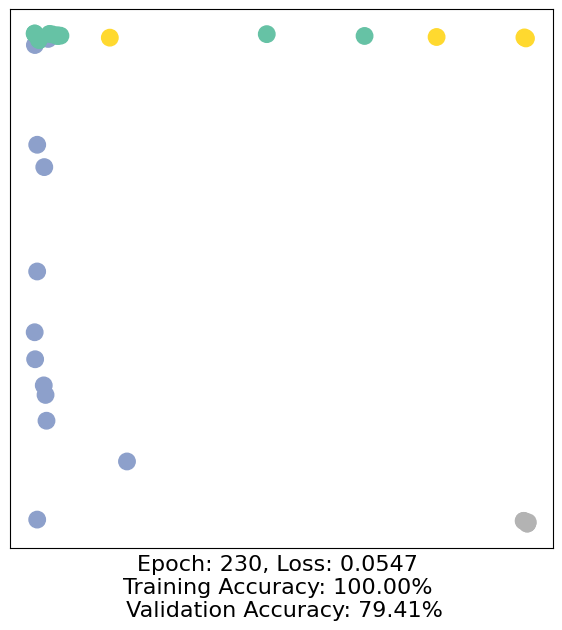

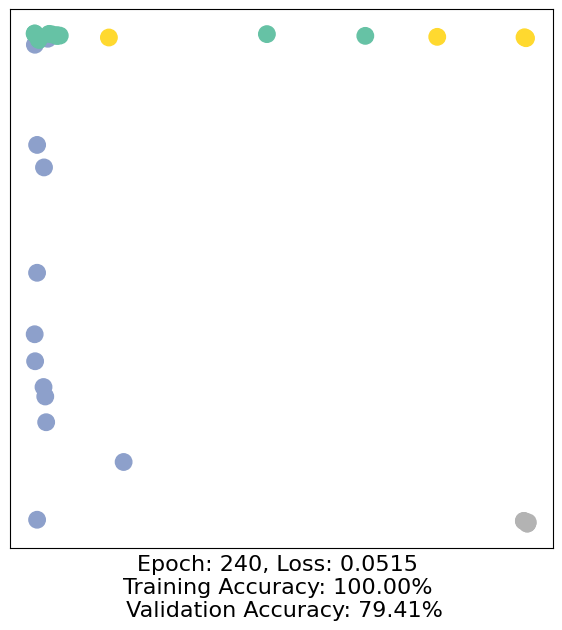

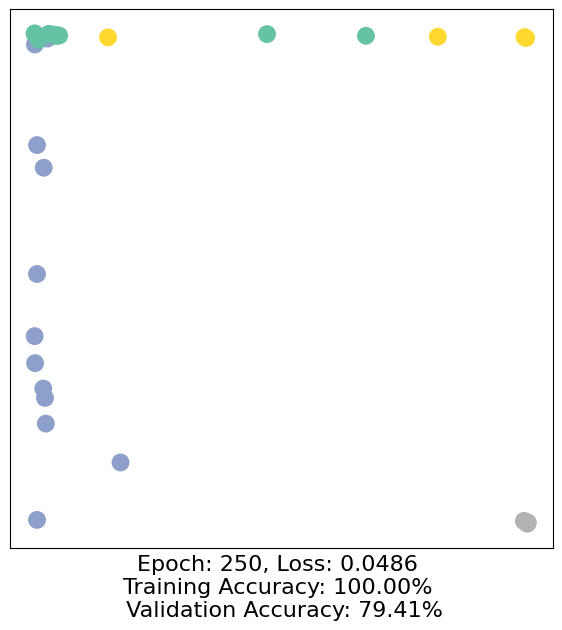

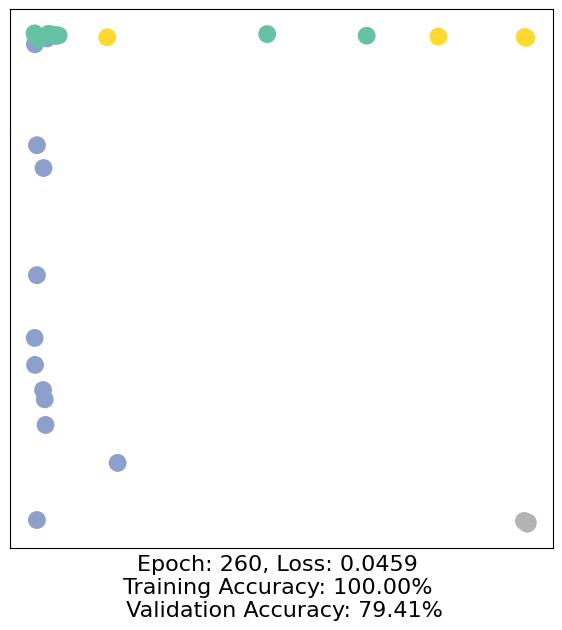

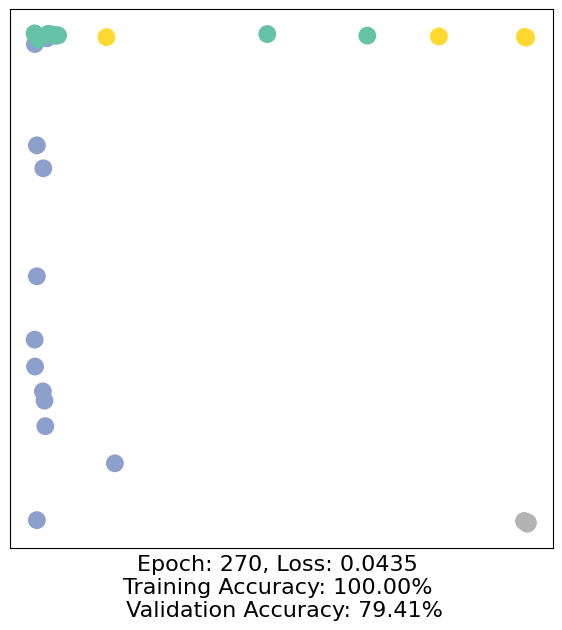

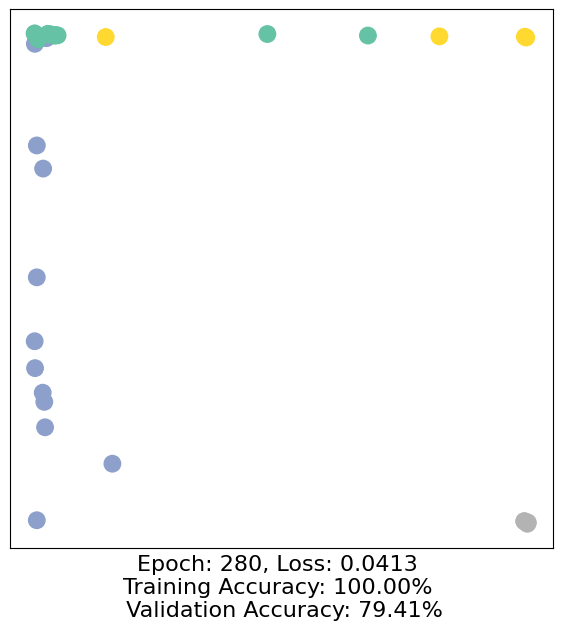

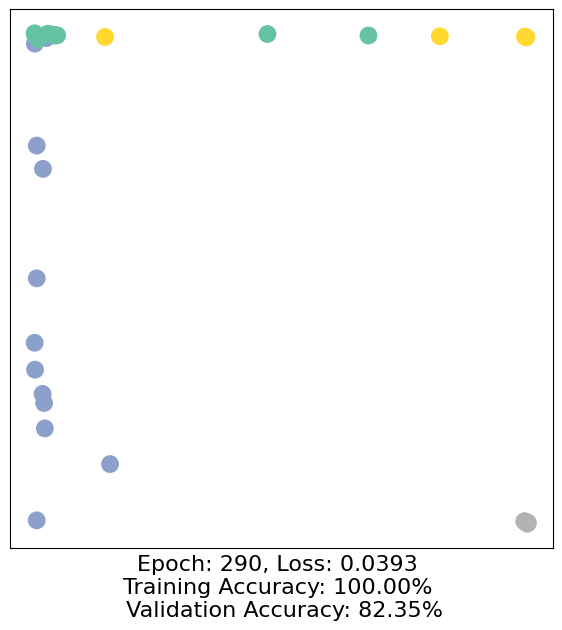

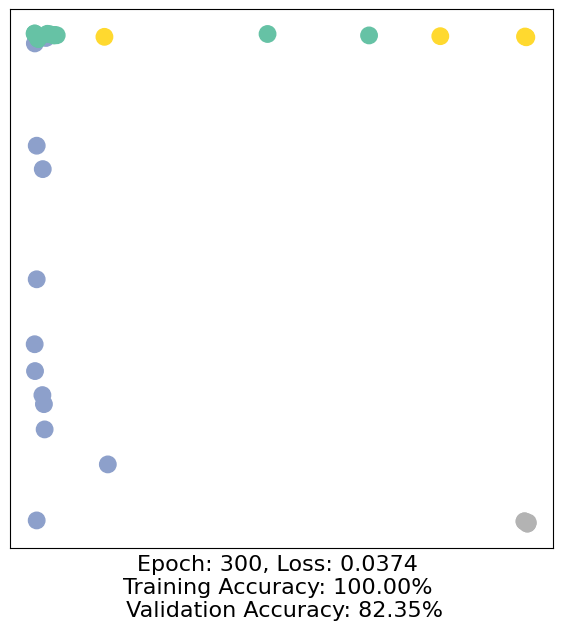

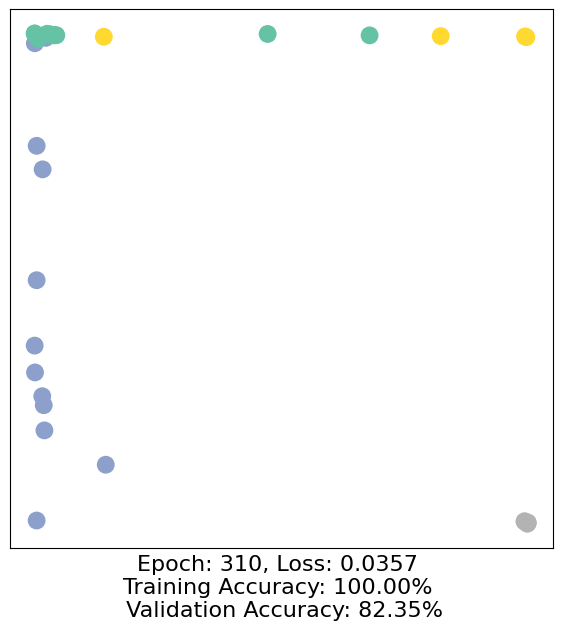

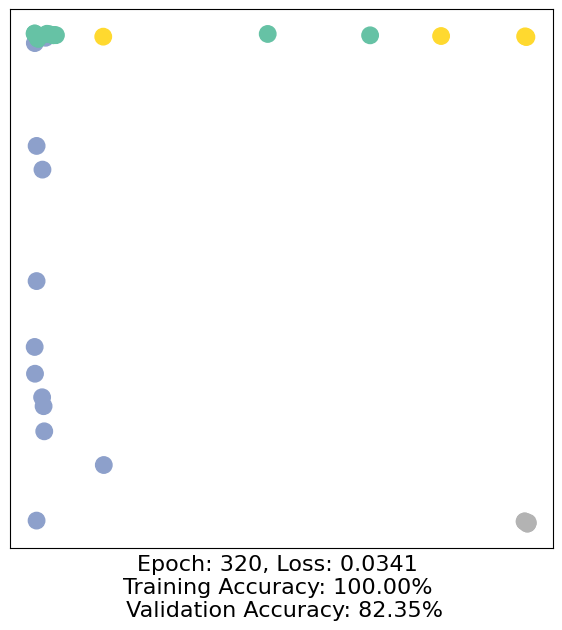

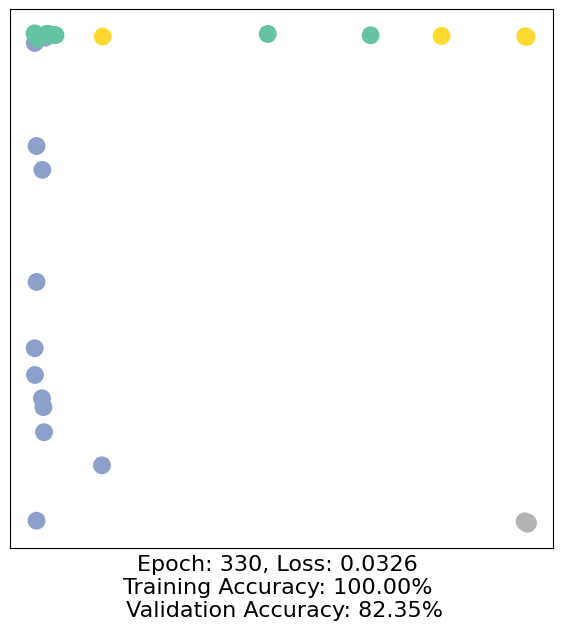

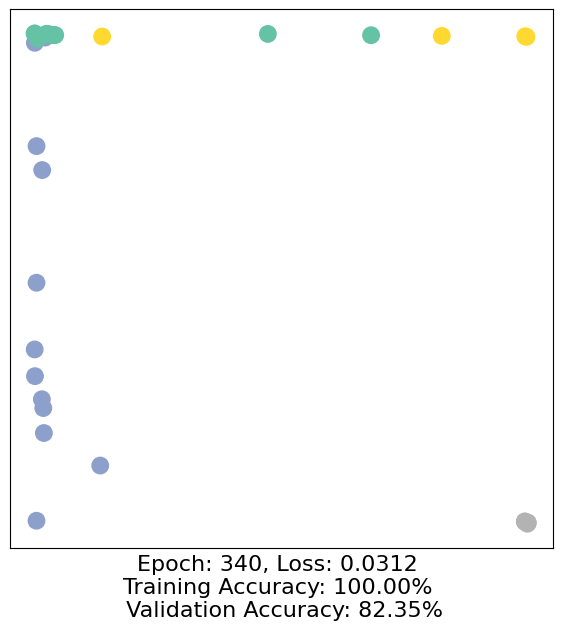

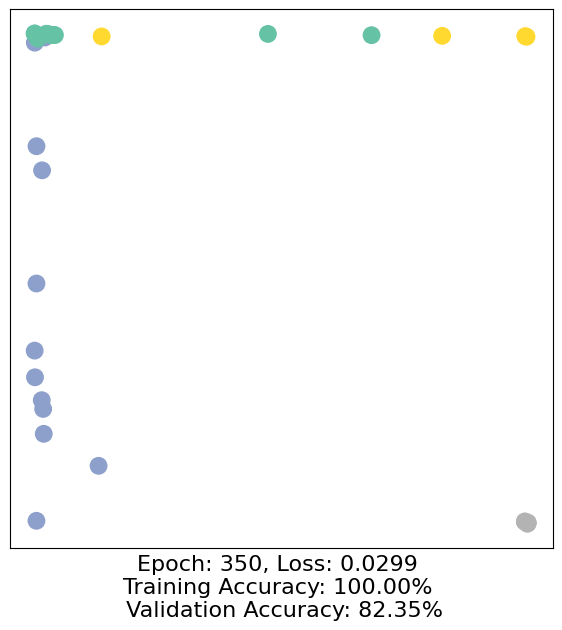

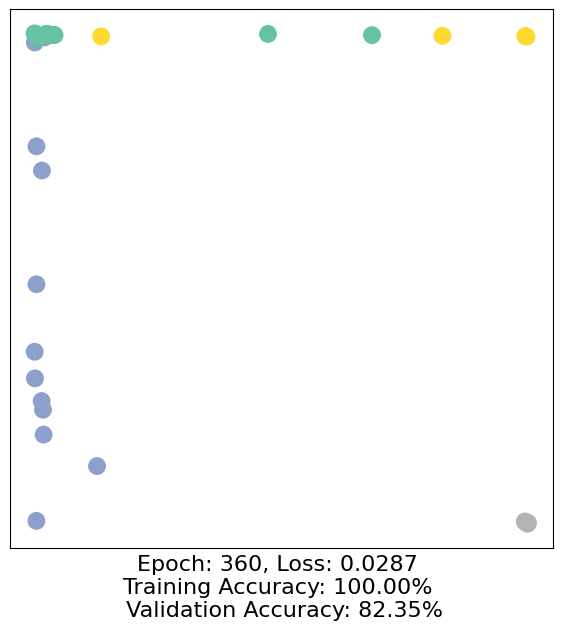

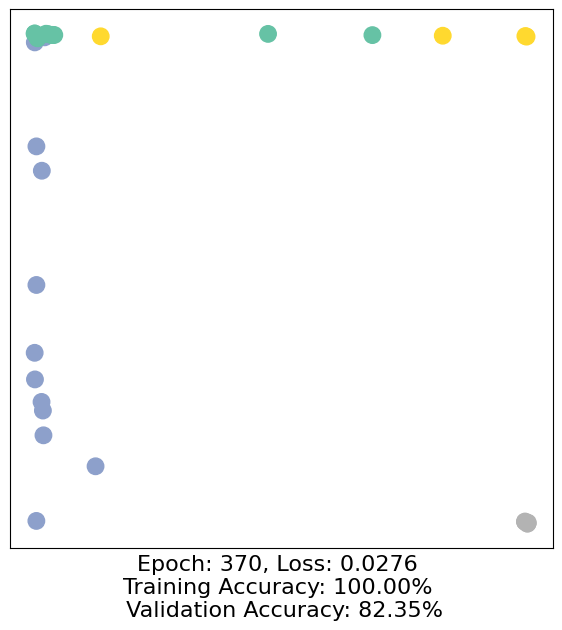

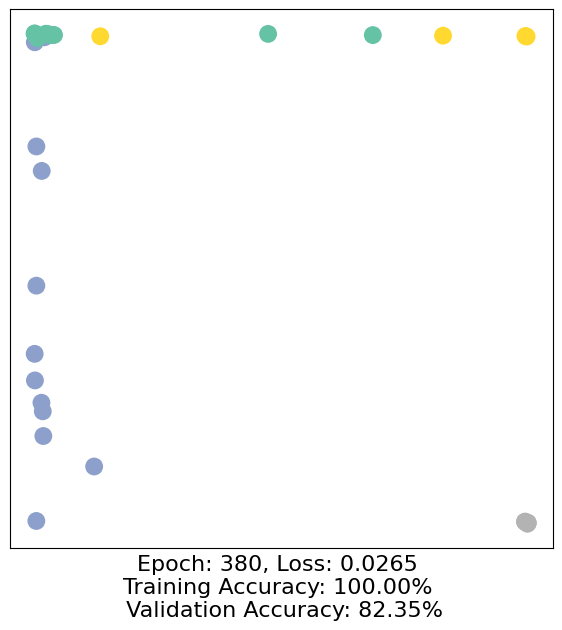

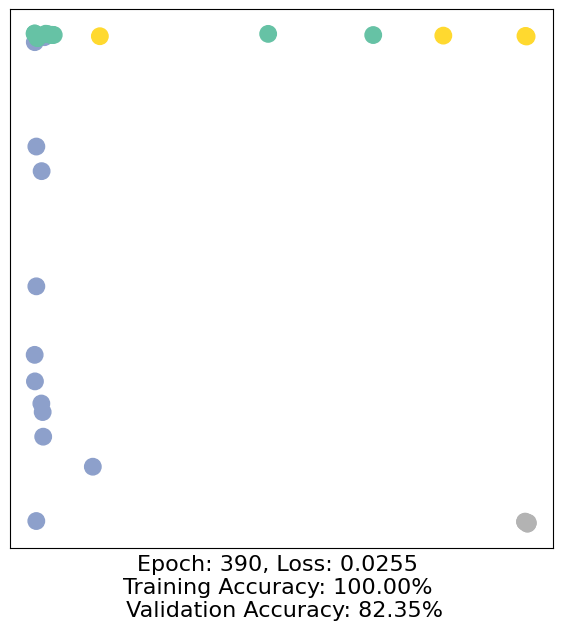

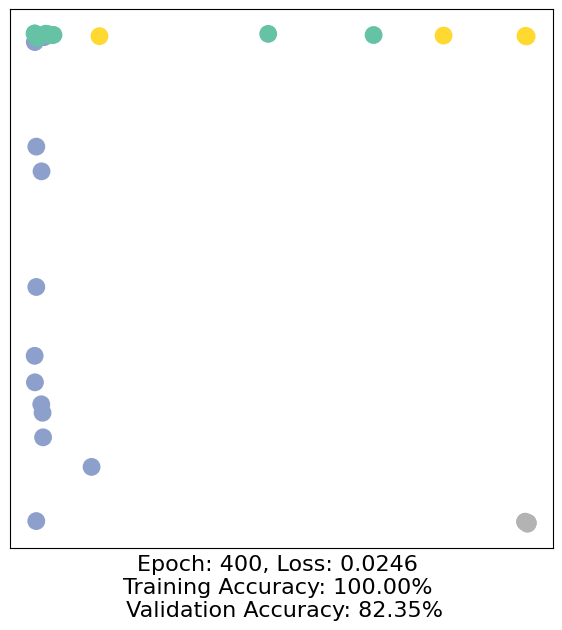

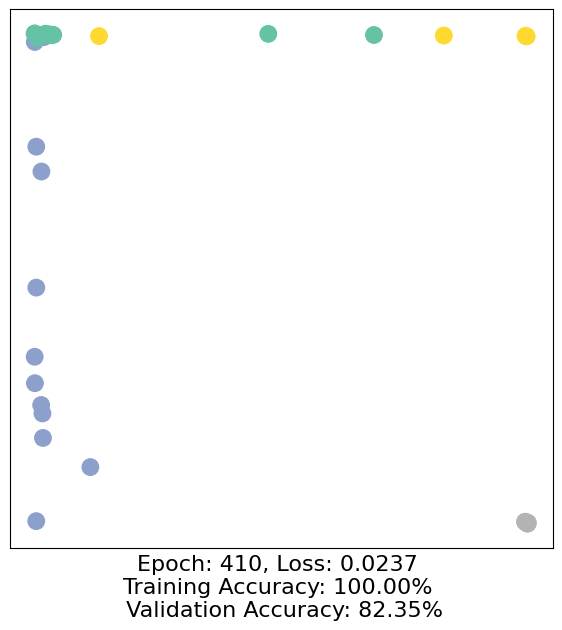

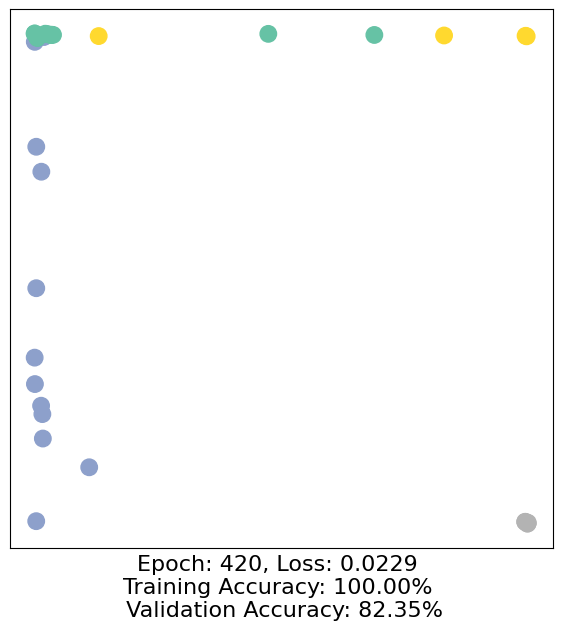

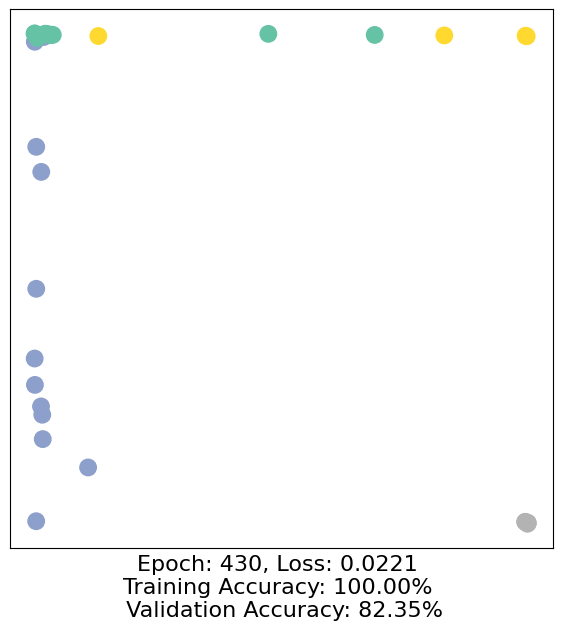

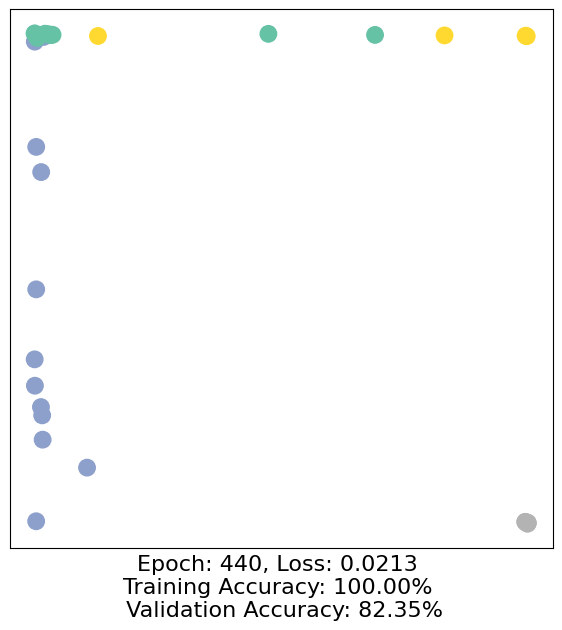

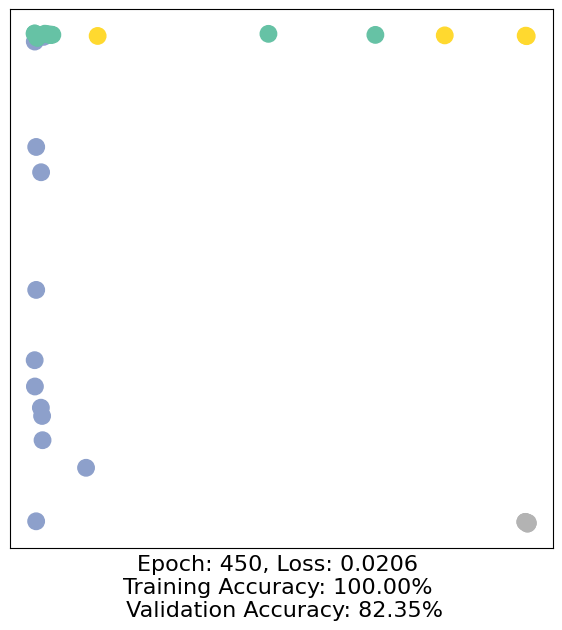

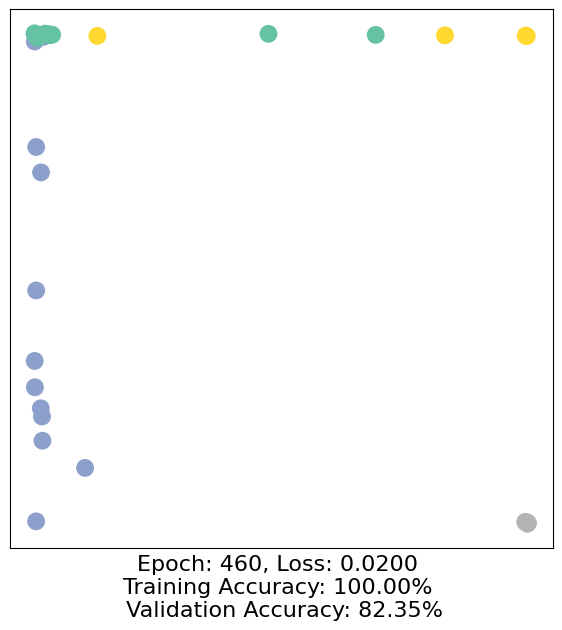

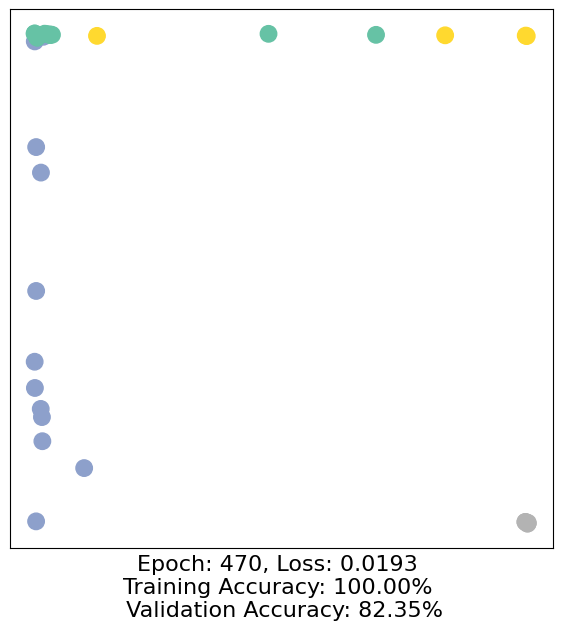

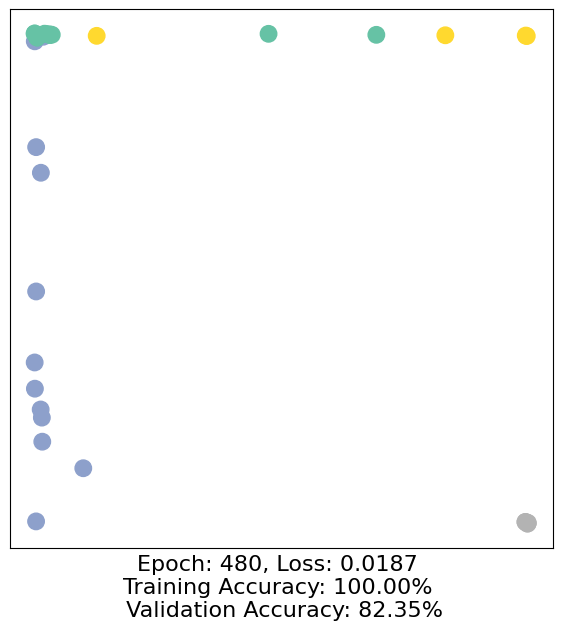

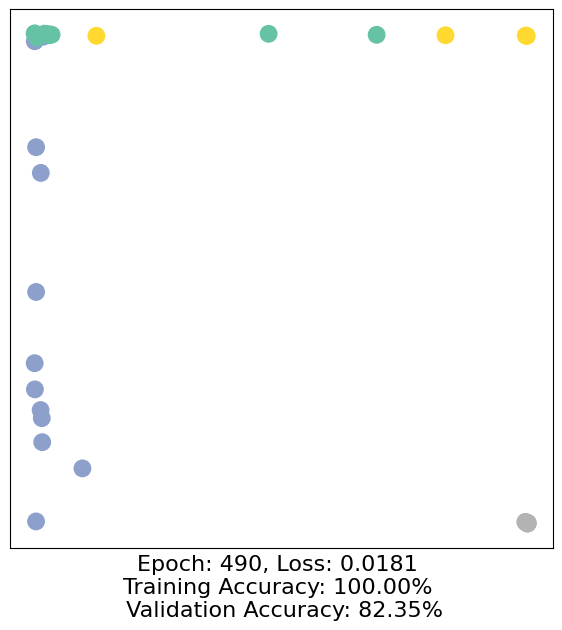

In [16]:
import time
from IPython.display import Javascript  # restringiamo l'altezza della cella di output.
display(Javascript('''setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # definiamo il criterio di loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # l'ottimizzatore

def train(data):
    optimizer.zero_grad()  # ripuliamo il gradiente.
    out, h = model(data.x, data.edge_index)  # Effettuiamo un singolo passo forward.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Calcoliamo la loss solo sui nodi di training.
    loss.backward()  # Deriviamo il gradiente.
    optimizer.step()  # Aggiorniamo i parametri in base al valore del gradiente.

    accuracy = {}
    # Calcoliamo l'accuratezza sul training sui 4 dati
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) 
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calcoliamo l'accuratezza di validazione sull'intero grafo 
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(500):
    loss, h, accuracy = train(data)
    # Visualizziamo gli embedding ongi 10 epoche
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.3)